In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score #cross validation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
# Read the sales data
file_path = Path("Resources/store_data.csv")
df = pd.read_csv(file_path)

# Display sample data
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Unit Price,Price without discount,Unit Cost
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0%,41.9136,130.9800,130.98,20.9568
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0%,219.5820,243.9800,243.98,73.1940
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0%,6.8714,7.3100,7.31,3.4357
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,45%,-383.0310,191.5155,348.21,80.0883
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,20%,2.5164,11.1840,13.98,4.0542


In [3]:
#Convert order date and ship date columns to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

df['Order Year'] = df['Order Date'].dt.year
df['Ship Year'] = df['Ship Date'].dt.year

In [4]:
# DF that shows sales by category
category_sales = df.groupby('Category')['Sales'].sum()
formatted_category_sales = category_sales.map('$ {:.2f}'.format)

category_sales_df = pd.DataFrame(formatted_category_sales)
category_sales_df

,Sales
Category,
Furniture,$ 741999.80
Office Supplies,$ 719047.03
Technology,$ 836154.03


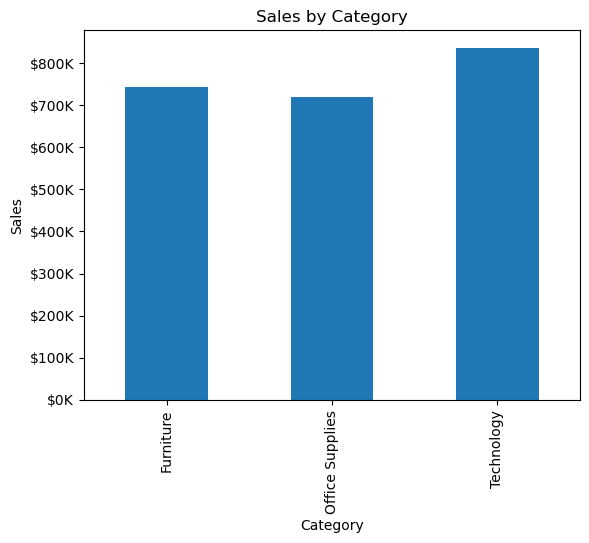

In [5]:
#Bar chart that shows sales by category
def currency_formatter(x, pos):
    return f"${x/1000:,.0f}K"


y_format = FuncFormatter(currency_formatter)
plt.gca().yaxis.set_major_formatter(y_format)

category_sales.plot(kind='bar')

plt.xlabel('Category')
plt.ylabel('Sales')
plt.title('Sales by Category')

plt.show()

In [6]:
# DF that shows sales by sub-category
sub_category_sales = df.groupby('Sub-Category')['Sales'].sum()
sub_category_sales = sub_category_sales.sort_values(ascending=False)
formatted_sub_category_sales = sub_category_sales.map('$ {:.2f}'.format)

sub_category_sales_df = pd.DataFrame(formatted_sub_category_sales)
sub_category_sales_df

,Sales
Sub-Category,
Phones,$ 330007.05
Chairs,$ 328449.10
Storage,$ 223843.61
Tables,$ 206965.53
Binders,$ 203412.73
Machines,$ 189238.63
Accessories,$ 167380.32
Copiers,$ 149528.03
Bookcases,$ 114880.00


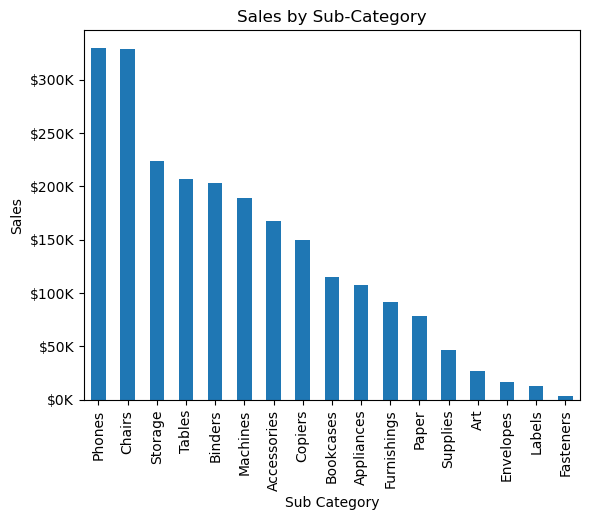

In [7]:
#Bar chart that shows sales by sub-category
def currency_formatter(x, pos):
    return f"${x/1000:,.0f}K"


y_format = FuncFormatter(currency_formatter)
plt.gca().yaxis.set_major_formatter(y_format)

sub_category_sales.plot(kind='bar')

plt.xlabel('Sub Category')
plt.ylabel('Sales')
plt.title('Sales by Sub-Category')

plt.show()

In [8]:
# DF that shows sales by category by year
category_sales_year = df.groupby(['Category', 'Order Year'])['Sales'].sum()

category_sales_year_df = pd.DataFrame(category_sales_year)

category_sales_year_df.reset_index(inplace=True)
category_sales_year_df

,Category,Order Year,Sales
0,Furniture,2014,157192.8531
1,Furniture,2015,170518.2370
2,Furniture,2016,198901.4360
3,Furniture,2017,215387.2692
4,Office Supplies,2014,151776.4120
5,Office Supplies,2015,137233.4630
6,Office Supplies,2016,183939.9820
7,Office Supplies,2017,246097.1750
8,Technology,2014,175278.2330
9,Technology,2015,162780.8090


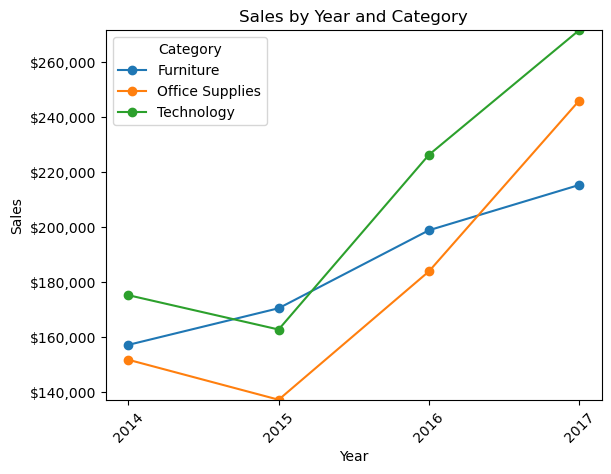

Category,Furniture,Office Supplies,Technology
Order Year,,,
2014,157192.8531,151776.412,175278.233
2015,170518.2370,137233.463,162780.809
2016,198901.4360,183939.982,226364.180
2017,215387.2692,246097.175,271730.811


In [9]:
# Line chart that shows sales by category by year
def currency_formatter(x, pos):
    return f"${x:,.0f}"

y_format = FuncFormatter(currency_formatter)

pivot_df = category_sales_year_df.pivot(index='Order Year', columns='Category', values='Sales')

for category in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[category], marker='o', label=category)

# Apply the y-axis label formatting
plt.gca().yaxis.set_major_formatter(y_format)

# Add labels and a title
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales by Year and Category')

# Show the legend
plt.legend(title='Category', loc='upper left')

# Automatically adjust the y-axis scale
plt.autoscale(enable=True, axis='y', tight=True)

x_values = pivot_df.index
plt.xticks(x_values, [int(x) for x in x_values], rotation=45)

# Show the chart
plt.show()
pivot_df

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in df.columns:
    if(df.dtypes[i] == 'object'):
        df[i] = le.fit_transform(df[i])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Row ID                  9994 non-null   int64         
 1   Order ID                9994 non-null   int32         
 2   Order Date              9994 non-null   datetime64[ns]
 3   Ship Date               9994 non-null   datetime64[ns]
 4   Ship Mode               9994 non-null   int32         
 5   Customer ID             9994 non-null   int32         
 6   Customer Name           9994 non-null   int32         
 7   Segment                 9994 non-null   int32         
 8   Country                 9994 non-null   int32         
 9   City                    9994 non-null   int32         
 10  State                   9994 non-null   int32         
 11  Postal Code             9994 non-null   int64         
 12  Region                  9994 non-null   int32   

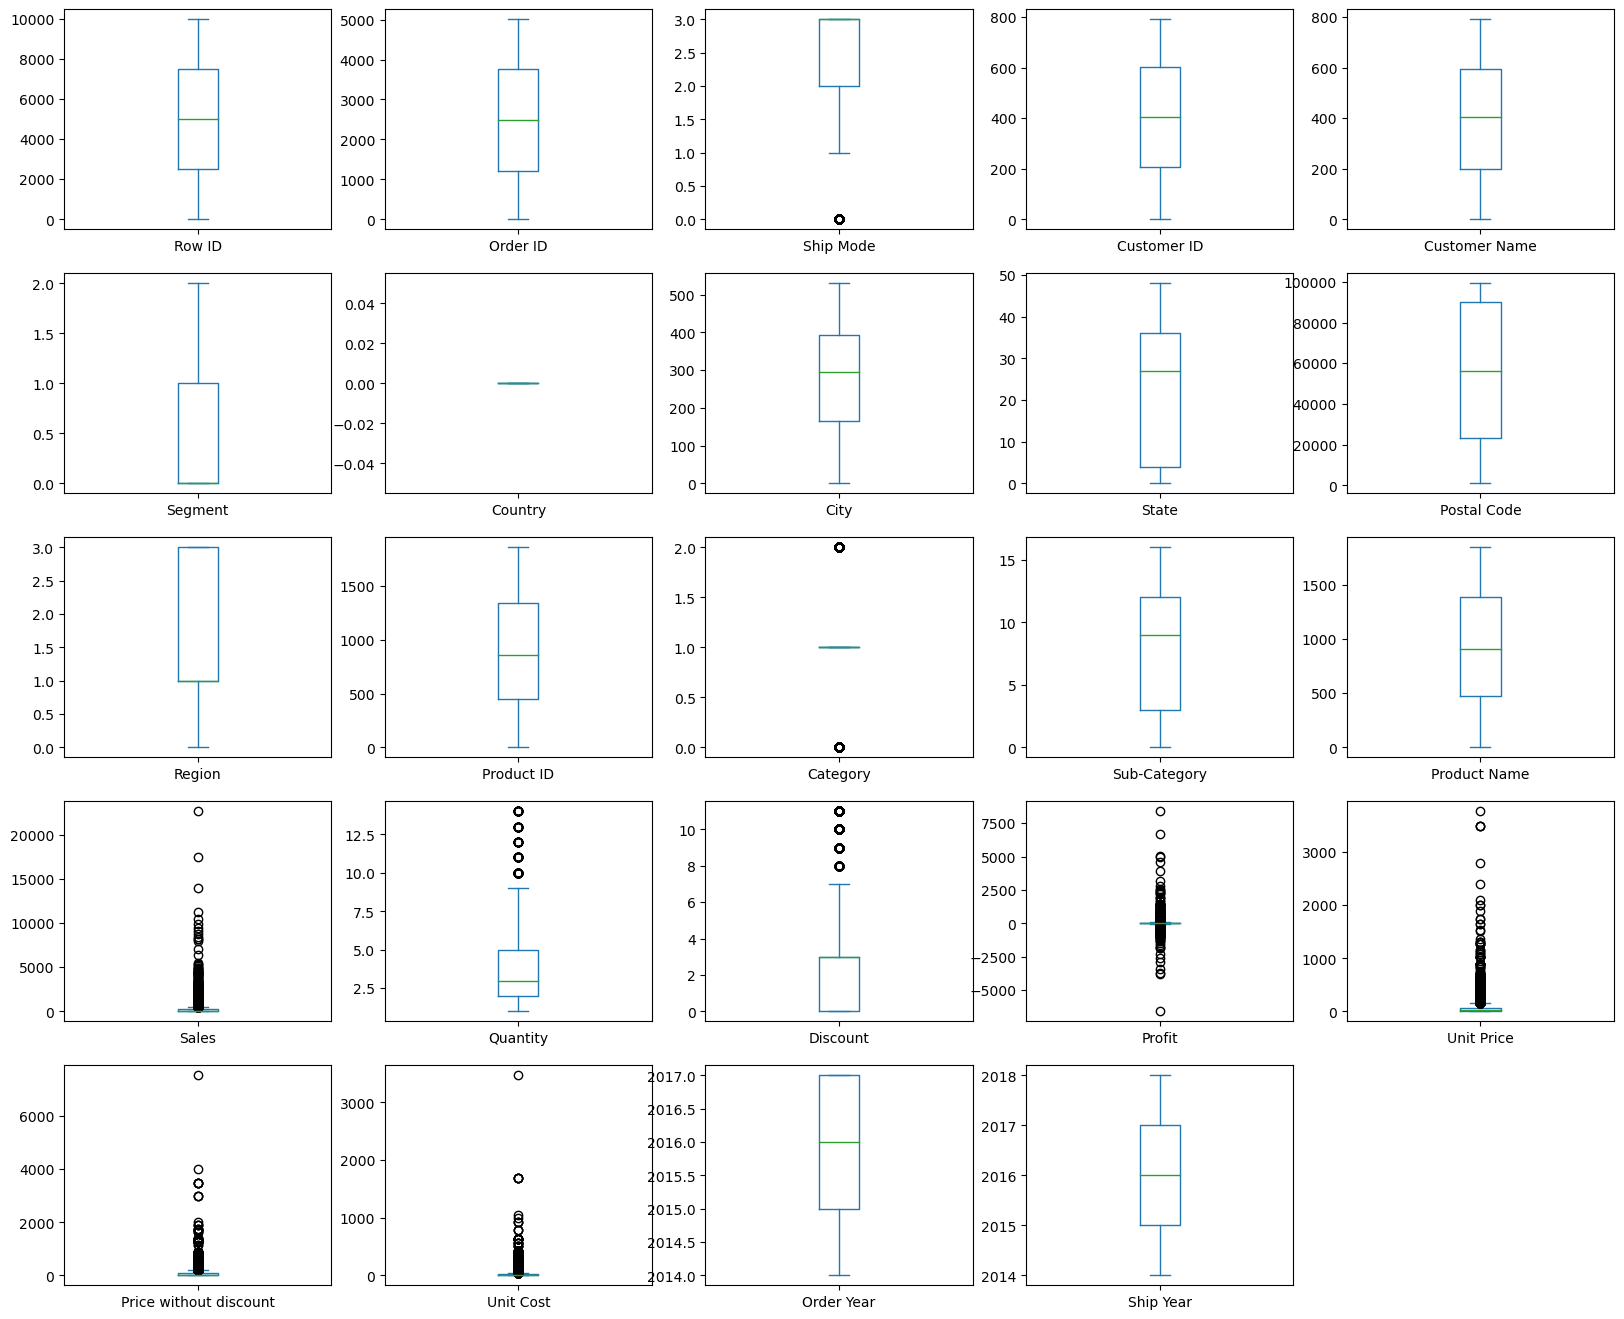

In [11]:
#representing the outliers
df.plot(kind='box', subplots=True, figsize=(20,20), layout=(6,5))
plt.show()

In [12]:
#cleaning up columns
df.drop(['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Country', 'Postal Code',
           'Region', 'Product ID', 'Product Name', 'Order Date', 'Order Year'], axis=1, inplace=True)
df.columns

Index(['Segment', 'City', 'State', 'Category', 'Sub-Category', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Unit Price',
       'Price without discount', 'Unit Cost', 'Ship Year'],
      dtype='object')

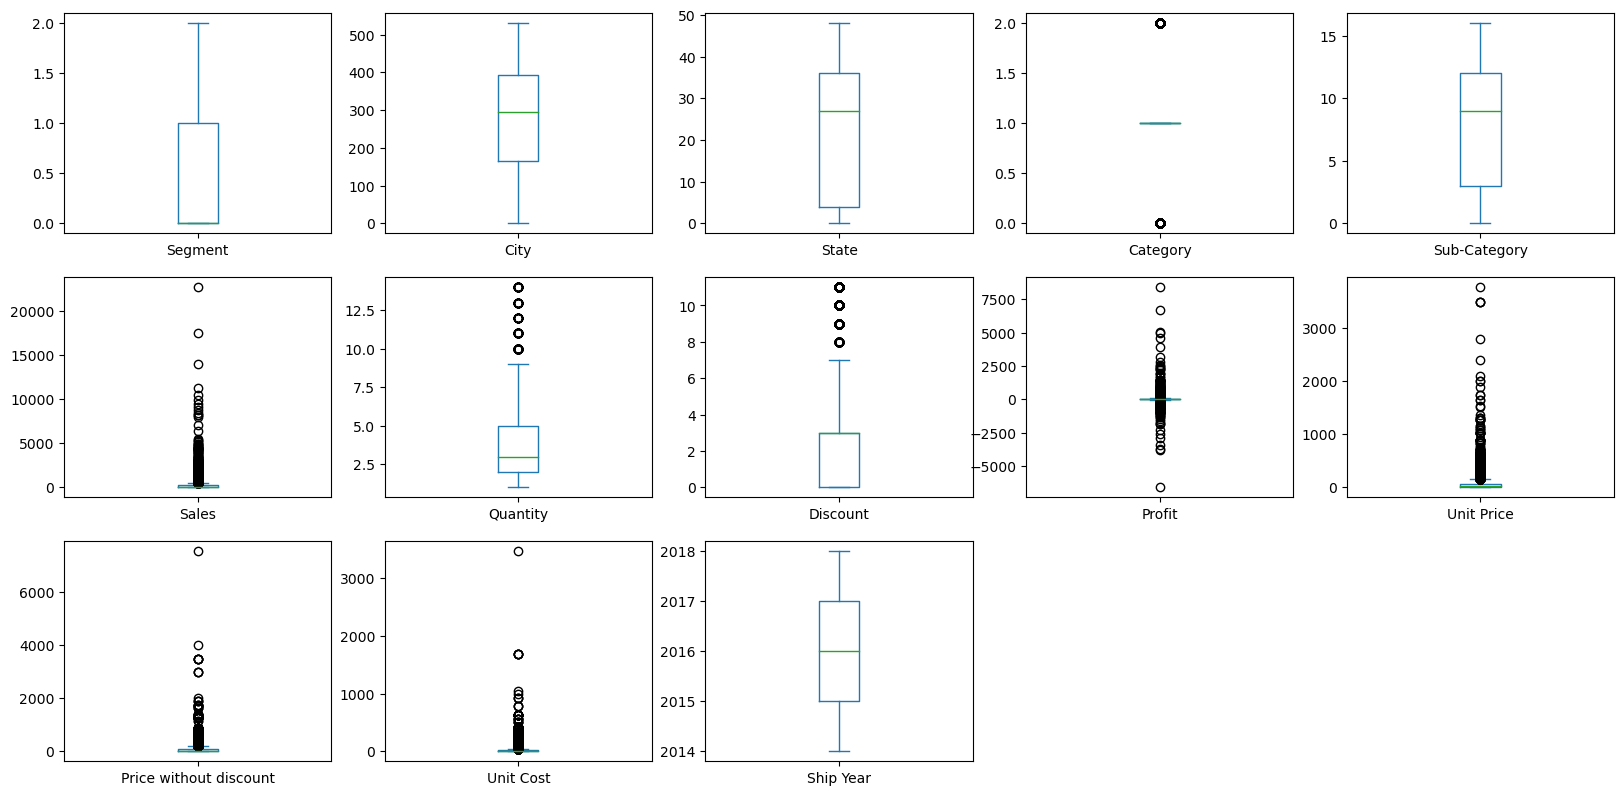

In [13]:
df.plot(kind='box', subplots=True, figsize=(20,20), layout=(6,5))
plt.show()

In [14]:
#deleting some of the outliers
print("Old Shape: ", df.shape[0])
df.drop(index= df[(df['Sales'] > 12000)].index, inplace=True)
df.drop(index= df[(df['Profit'] > 5000) | (df['Profit'] < -3000)].index, inplace=True)
df.drop(index= df[(df['Discount'] >= 7)].index, inplace=True)
df.drop(index= df[(df['Quantity'] > 10)].index, inplace=True)
print("NEW Shape: ", df.shape[0])

Old Shape:  9994
NEW Shape:  8950


In [15]:
# Split target column from dataset
y = df['Sales']
X = df.drop(['Sales'], axis=1)

In [16]:
# Preview the data
X[:5]

,Segment,City,State,Category,Sub-Category,Quantity,Discount,Profit,Unit Price,Price without discount,Unit Cost,Ship Year
0,0,194,15,0,4,2,0,41.9136,130.980,130.98,20.9568,2016
1,0,194,15,0,5,3,0,219.5820,243.980,243.98,73.1940,2016
2,1,266,3,1,10,2,0,6.8714,7.310,7.31,3.4357,2016
4,0,153,8,1,14,2,3,2.5164,11.184,13.98,4.0542,2015
5,0,266,3,0,9,7,0,14.1694,6.980,6.98,2.0242,2014


In [17]:
# Print first five entries for target
y[:5]

0    261.960
1    731.940
2     14.620
4     22.368
5     48.860
Name: Sales, dtype: float64

In [19]:
# Split the dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
# Create the StandardScaler instance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [21]:
X_train.shape

(5996, 12)

In [22]:
X_test.shape

(2954, 12)

In [23]:
# Create a random forest regressor
rf_regressor = RandomForestRegressor(n_estimators=150,max_depth=7,random_state=5)

In [24]:
# Fitting the model
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=150, random_state=5)

In [25]:
#Compute and return the scores from the model
print("Random Forest Regressor")
print(rf_regressor.score(X_train, y_train))
print(rf_regressor.score(X_test, y_test))

Random Forest Regressor
0.9921321788699508
0.9777582877089737


In [26]:
#Run feature analysis
rf_regressor.feature_importances_

array([1.89365396e-03, 2.36171649e-03, 1.22683158e-03, 4.53887859e-04,
       1.84161144e-03, 1.47757742e-01, 1.78861492e-03, 1.12326140e-01,
       6.24834901e-01, 1.00016487e-01, 3.92184946e-03, 1.57656354e-03])

In [27]:
#Match feature importance with the respective category and put into a dataframe
importances_df = pd.DataFrame(sorted(zip(rf_regressor.feature_importances_, X.columns), reverse=True))
importances_df

,0,1
0,0.624835,Unit Price
1,0.147758,Quantity
2,0.112326,Profit
3,0.100016,Price without discount
4,0.003922,Unit Cost
5,0.002362,City
6,0.001894,Segment
7,0.001842,Sub-Category
8,0.001789,Discount
9,0.001577,Ship Year


<Axes: title={'center': 'Features Importances'}, ylabel='1'>

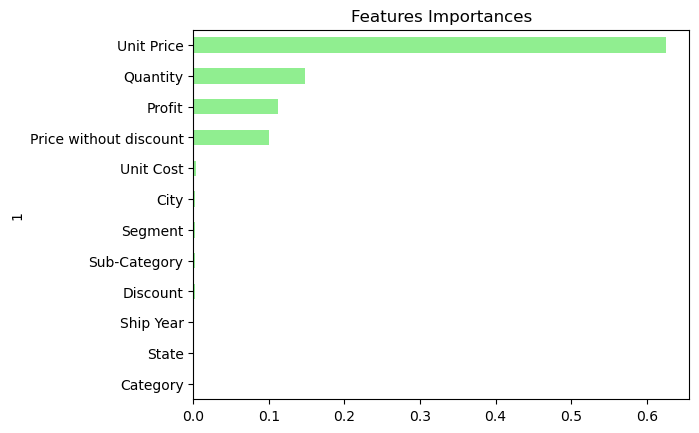

In [28]:
# Visualize the features by importance
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

Random Forest Regressor
Train Score: 0.9921321788699508
Test Score: 0.9777582877089737
Reg_score: 0.9777582877089737
Mean Squared Error: 5392.235110317648
Mean absolute percentage error: 0.26326833703070907
Mean absolute error: 17.224882054848127
rmse: 73.43183989467816


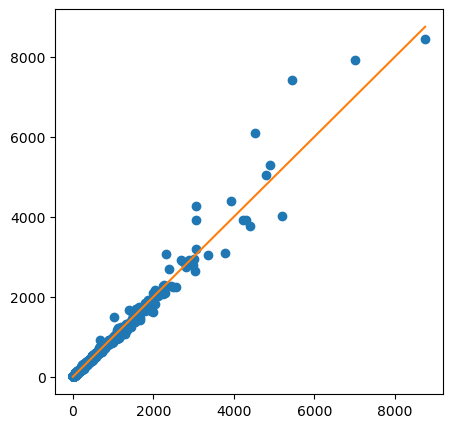

In [29]:
#Run predictions
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(y_test , y_pred)
mae = mean_absolute_error(y_test , y_pred)
reg_score = r2_score(y_test, y_pred)
print("Random Forest Regressor")
print("Train Score:", rf_regressor.score(X_train, y_train))
print("Test Score:", rf_regressor.score(X_test, y_test))
print('Reg_score:', reg_score )
print('Mean Squared Error:', mse)
print('Mean absolute percentage error:', mape )
print('Mean absolute error:', mae)
print('rmse:', rmse)

#Plot the results
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.errorbar(y_test, y_pred, fmt='o')
ax.errorbar([1, y_test.max()], [1, y_test.max()])
plt.show()
print()